In [ ]:
# TODO
# 1. Complete make_one_shot_task
# 2. Complete test one shot task
# 3. Complete plotting
# 4. See if using attention with some static probabilities help the detection of spoofing
# 5. Look at triple loss and computing it
# 6. CNN and attention to top of the book - https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6
    #Propose probabilities learnt through an LSTM network 
# 7. Higher prediction probabilities for top of book
    #https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
# 8. Fuck with data to get the desired result -b rebuild project
# 9. Clean up code, make fancy plots, write comments and so on
# 10. See if using LSTM to learn probabilities for attention would work 
# 11. Learn Families of classes for spoofing 
# 12. Custom loss function for family of identifications
# 13. Cross Modal for price and qty - https://iclr.cc/virtual/poster_B1lJzyStvS.html
# 14. Mutual information for either layering or other task - https://iclr.cc/virtual/poster_rkxoh24FPH.html, https://openreview.net/forum?id=rkxoh24FPH
# 15. Time seires with triplet leraning - https://papers.nips.cc/paper/8713-unsupervised-scalable-representation-learning-for-multivariate-time-series.pdf
# 16. Quadraple Learning - https://www.youtube.com/watch?v=_o2SLgjejAE
# 17. Add 13/14/15/16 for the work

In [ ]:
# TODO to make this PERFECT
# 1. Normalise all data - DONE
# 2. Use prices as well - Explore various convolutions whether depth wise or 3d and so on - https://keras.io/layers/convolutional/ - DONE
# 3. Bias / Weights inititalisation
# 4. Get better data generating process - DONE
# 5. Use the new data for better prediction. Some changes to Y variable and so on. 
# 6. Do spoof buy and sell labels
# 6. Create better images of the classes
# 7. Get proper error rate
# 8. Improve the network
!pip install keras-tcn==2.8.3

##### RESULTS
1. No-Change Unnormalised Loss : 0.012634731829166412
2. Normalised Loss without anchor normalisation : 0.5267388820648193
3. Normalised Loss with anchor : 0.20129983127117157

In [316]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)

import config
import spoof_ground_truth
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from imageio import imread
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import time
import numpy.random as rng
import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, Activation, concatenate, Dropout, Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.utils import plot_model,normalize
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler, OneHotEncoder
from skimage.util.shape import view_as_windows
from tcn import TCN
from tensorflow_addons.losses import triplet_semihard_loss
from tqdm import tqdm

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [42]:
# Hyperparameters
n_iteration=0
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)

# Hyper parameters
evaluate_every = 500 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 2000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

### Data Loading and Cleansing

In [138]:
abeo_train = np.load(project_path + '/data/train/20160901/ABEO_BATS.npy')
abeo_val = np.load(project_path + '/data/train/20160901/ABEO_NASDAQ.npy')


#goog_train_bid = np.load(project_path + '/data/train/bid/20160901/GOOG_BATS.npy')
#goog_train_ask = np.load(project_path + '/data/train/ask/20160901/GOOG_BATS.npy')

#goog_val_bid = np.load(project_path + '/data/train/bid/GOOG_NASDAQ.npy')
#goog_val_ask = np.load(project_path + '/data/train/ask/GOOG_NASDAQ.npy')

model_path = project_path + '/weights/spoof'
model_cp_path = project_path + '/check_point/spoof'

In [14]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler(with_mean=False)
qq = QuantileTransformer()
data = np.array([9.7, 9.5, 9.3, 8.1])
data_r = data.reshape(-1, 1)
x = min_max_scaler.fit_transform(data_r)
y = scaler.fit_transform(data_r)
z = qq.fit_transform(data_r)
#print(x)
#print(y)
#print(z)

#print(spoof_ground_truth.spoof_step1_truth1[:,1])
a = spoof_ground_truth.spoof_step1_truth1[:,0].reshape(2, 30, 1)
b = spoof_ground_truth.spoof_step1_truth1[:,1].reshape(2, 30, 1)
c = np.dstack((a,b))
print(c.shape)
#print(spoof_ground_truth.spoof_type_one.reshape(2,10,3,11))

(2, 30, 2)


In [522]:
def retrieve_cleansed_data(lob, width=200):
    # when you do view below it gives you 0 and yhen evrything after
    #   print(lob_states[19])
    #  print(Y_labels[19]) - abeo arca test case
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    quantile_transformer = QuantileTransformer()
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
     
    #print(lob['quantity'][:,0,0,0:15].shape)
    #print(lob['quantity'][:,:,0,0:15].shape)
    # As evidenced by above, we can technically select all in the second axis as there is only 1 element. However, 
    # because we need a 2d input we make it 0. The 3rd axis is side so we need this
    lob_qty_buy = pd.DataFrame(lob['quantity'][:,0,0,0:15])
    max_buy = np.amax(lob_qty_buy, axis=1)
    lob_qty_buy = lob_qty_buy.replace(0, np.NaN)
    avg_buy = lob_qty_buy.mean().mean()
    vol_sum_buy = lob_qty_buy.sum(axis=1)
    
    lob_qty_sell = pd.DataFrame(lob['quantity'][:,0,1,0:15])
    max_sell = np.amax(lob_qty_sell, axis=1)
    lob_qty_sell = lob_qty_sell.replace(0, np.NaN)
    avg_sell = lob_qty_sell.mean().mean()
    vol_sum_sell = lob_qty_sell.sum(axis=1)
    
    vol_imbalance = (vol_sum_buy - vol_sum_sell) / (vol_sum_buy + vol_sum_sell)
    vol_imbalance = (vol_sum_buy - vol_sum_sell) / (vol_sum_buy + vol_sum_sell)
    
    label_df = pd.concat([vol_imbalance, pd.Series(lob['action'].ravel()), pd.Series(lob['side'].ravel()), 
                         max_buy, max_sell], axis=1)
    label_df[5] = label_df[0].diff() # Change in the values of the two states of OB (We take diff of prev row)
    label_df[6] = 0
  
    label_df[6] = np.where(((label_df[1] == 2) & (label_df[2] == 'B') & (np.abs(label_df[5]) > 0.09) & 
                            (label_df[3] > avg_buy)), 1, 
                             np.where(((label_df[1] == 2) & (label_df[2] == 'S') & (np.abs(label_df[5]) > 0.09) &
                                       (label_df[3] > avg_sell)), 2, label_df[6].values))
    label_df = label_df.iloc[width-1:]
    Y_labels = label_df[6].reset_index(drop=True)
   
    # Normalise positive samples
    # these array manipulations are to get a final array where b-s in same array group
    lob_n, d, w, h = lob['quantity'].shape
    b_qty = lob['quantity'][:,0,0,:]
    s_qty = lob['quantity'][:,0,1,:]
    lob_qty = np.stack((b_qty, s_qty), axis=2)
   # print(lob_qty[6])
   # print('Second After Reshape')
   # print(lob['quantity'][6])
    lob_qty = lob_qty.ravel()
   # lob_qty = min_max_scaler.fit_transform(lob_qty)
    lob_qty = lob_qty.reshape(lob_n, h, w)
   # print(lob_qty[6])
    
    
    b_price = lob['price'][:,0,0,:]
    s_price = lob['price'][:,0,1,:]
    lob_price = np.stack((b_price, s_price), axis=2)
   # print(lob_price[6])
    #print('Second After Reshape')
    lob_price = lob_price.ravel()
    #lob_price = quantile_transformer.fit_transform(lob_price)
    lob_price = lob_price.reshape(lob_n, h, w)
    #print(lob_price[6])
    
    triplets = np.zeros((1, 3, 2, 13)) 
 #   print(triplets[0])
    #lob_orderid = lob['order_id'].reshape(-1,1)
    #lob_orderid = one_hot_encoder.fit_transform(lob_orderid)
    #lob_orderid = lob_orderid.reshape(lob_n, h, w, d)

    #print(lob_price[6])
    lob_states = np.stack((lob_qty, lob_price), axis=-1)
   # print(lob_states[6])
    lob_states = lob_states.reshape(lob_n, h, w, 2)
    print('Second After Reshape')
    #print(lob_states[6])
    lob_states = view_as_windows(lob_states,(width,1,1,1))[...,0,0,0].transpose(0,4,1,2,3)
   # print(lob_states[6])
    # TODO : TEST CASE ASSERT WITH WIDTH = 2 and CHECK ALL CORRECT
   #
   # print(lob_states[19])
  #  print(Y_labels[19])
    print(lob_states.shape)
    print(Y_labels.shape)
    return lob_states, Y_labels


X_train, Y_train = retrieve_cleansed_data(abeo_val)
X_test, Y_test = retrieve_cleansed_data(abeo_train)




Second After Reshape
(3243, 200, 30, 2, 2)
(3243,)
Second After Reshape
(1606, 200, 30, 2, 2)
(1606,)


In [ ]:
def combine_pos_neg(pos_sample, neg_sample, pos_target=None, neg_target=None):
    """
    Combines positive and negative samples into one sample set and returns a dataset that can be used for train/test
    or validation. 
    
    Parameters
    ----------
    pos_sample : ndarray of shape (n_features,)
        Positive cleansed and normalised data 
    neg_sample : ndarray of shape (n_features,)
        Negative cleansed and normalised data 
    pos_target : ndarray of shape (n_features,)
        Target classes if exist 
    neg_target : ndarray of shape (n_features,)
        Target classes if exist 
    """
        
    list_of_samples = []
    sample = np.append(pos_sample, neg_sample, axis=0)
    target = np.append(np.ones(pos_sample.shape[0]), np.zeros(neg_sample.shape[0]))
    sample, target = shuffle(sample, target)
    list_of_samples = [pos_sample, neg_sample]
    return sample, target, list_of_samples

#anchor, pos_test, neg_test = retrieve_cleansed_data(abeo_val_pos, 
     #                                               abeo_val_neg, spoof_ground_truth.spoof_step1_truth1, 'B')
#anchor, pos_val, neg_val = retrieve_cleansed_data(goog_val_pos, goog_val_neg, 
   #                                               spoof_ground_truth.spoof_step1_truth1, 'B')

#x_train, y_train, list_of_train = combine_pos_neg(pos_train, neg_train)
#x_test, y_test, list_of_test = combine_pos_neg(pos_test, neg_test)
#x_val, y_val, list_of_val = combine_pos_neg(pos_val, neg_val)

### Model Initialisation

In [324]:
import numpy as np

input_x = np.zeros((3442, 5))
print(input_x.shape)
input_x = np.delete(input_x, np.s_[:2], axis=0)
#out = view_as_windows(input_x,(200,1))[...,0].transpose(0,1,2)
print(input_x.shape)


(3442, 5)
(3440, 5)


In [137]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

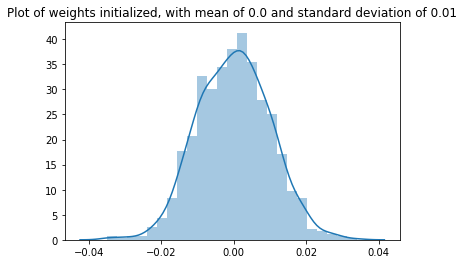

In [3]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

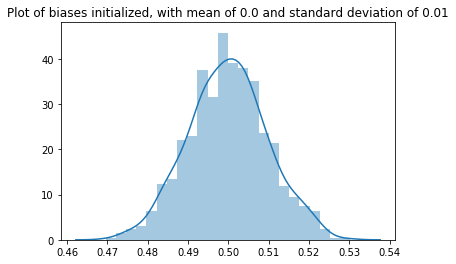

In [4]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [ ]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                     use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same", input_shape=input_shape,
                     use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    # model.add(MaxPooling2D())
    #model.add(Conv2D(128,kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
     #                use_bias = True, kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='random_uniform',bias_initializer=initialize_bias))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

     # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net
    
model = get_siamese_model((2, 30, 1))
model.summary()
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [36]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        """
        Implementation of the triplet loss as defined by formula (3)

        Arguments:
        y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
        y_pred -- python list containing three objects:
                anchor -- the encodings for the anchor images, of shape (None, 128)
                positive -- the encodings for the positive images, of shape (None, 128)
                negative -- the encodings for the negative images, of shape (None, 128)

        Returns:
        loss -- real number, value of the loss
        """
        anchor, positive, negative = inputs
        ### START CODE HERE ### (≈ 4 lines)
        # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
        pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
        print(pos_dist)
        # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
      #  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)

        hardest_positive_dist = tf.reduce_max(tf.square(tf.subtract(anchor, positive)), axis=-1)
        print(hardest_positive_dist)
        tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

        # shape (batch_size
        hardest_negative_dist = tf.reduce_min(tf.subtract(anchor, negative), axis=-1)
        tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

         # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + self.alpha, 0.0)

        # Get final mean triplet loss
        triplet_loss = tf.reduce_mean(triplet_loss)

        # Step 3: subtract the two previous distances and add alpha.
       # basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
        # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
        loss = tf.reduce_sum(tf.maximum(triplet_loss, 0))
        ### END CODE HERE ###
        return loss
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [39]:
def embedding_model(num_frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(num_frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    out = Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
   # out = MaxPooling2D()(out)
    out = Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same",
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
    out = Conv2D(128, kernel_size=(1,1), activation='relu', strides=1, padding="same",
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(out)
    out = TCN(nb_filters=128)(out)
   # out = Flatten()(out)
    out = Dense(256, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)
   # L1_layer = Lambda(lambda tensors:tf.math.l2_normalize(tensors, axis=1))
    #out = L1_layer(out)    
    return Model(inputs=inp, outputs=out)


def triplets_model(input_shape, embedding, include_top=False, pooling=None):

    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    # Get the embedded values
    encoded_a = embedding(anchor_input)
    encoded_p = embedding(positive_input)
    encoded_n = embedding(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=0.2,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    triplet_net = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    return triplet_net

build_embedding = embedding_model(200, 30, 2, 2, input_shape=(200, 30, 2, 2), dimensions=60)
build_triplet = triplets_model(input_shape=(200, 30, 2, 2), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=None,optimizer=optimizer)
build_embedding.summary()
build_triplet.summary()
#plot_model(build_triplet, show_shapes=True, show_layer_names=True, to_file='02 model.png')

Tensor("triplet_loss_layer_9/Sum:0", shape=(None,), dtype=float32)
Tensor("triplet_loss_layer_9/Max:0", shape=(None,), dtype=float32)
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200, 30, 2, 2 0                                            
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, 30, 2, 2)     0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 30, 2, 32)    96          lambda_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 30, 2, 64)    184

/Users/kaushalyakularatnam/Software/anaconda3/anaconda3/envs/py37/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output triplet_loss_layer missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to triplet_loss_layer.
  'be expecting any data to be passed to {0}.'.format(name))


### Training Triplet Net

In [516]:
def get_triplet_batch(batch_size, samples, labels, anchor):
    n_examples, time_axis, d, w, h = samples.shape
    triplets = [np.zeros((batch_size, 5, 2, 13)) for i in range(3)]
    print(triplets[0])
    
    # initialize vector for the targets
    targets = np.ones((batch_size,3))
    targets[:,2] = 0
    
    for i in range(batch_size):
        idx_p = rng.randint(0, n_examples_p)
        idx_n = rng.randint(0, n_examples_n)
        triplets[0][i,:,:,:] = anchor.reshape(w, h, 2)
        triplets[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 2)
        triplets[2][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 2)
    return [triplets[0], triplets[1], triplets[2]], [targets[:,0], targets[:,1], targets[:,2]]

def get_triplet_batch_spoof(batch_size, lob_states, labels):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
   
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]
    
    for i in range(batch_size):
        idx_a = labels_b.sample(1)
        idx_p = labels_b.sample(1)
        idx_n = labels_s.sample(1)
        triplets[0][i,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:] = lob_states[idx_n]
    return [triplets[0], triplets[1], triplets[2]]

def get_triplet_batch_new(batch_size, lob_states):
    n_samples, states, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, states, h, w, d)) for i in range(3)]
    
    for i in range(batch_size):
        idx_p = rng.randint(0, n_samples)
        idx_n = rng.randint(0, n_samples)
        idx_a = rng.randint(0, n_samples)
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
    return [triplets[0], triplets[1], triplets[2]]

def triplet_generator(batch_size, positive_samples, neg_train, anchor):
    while True:
        inputs, targets = get_triplet_batch(batch_size, positive_samples, neg_train, anchor)
        label = None
        yield ({'anchor_input': inputs[0], 'positive_input': inputs[1], 'negative_input': inputs[2]},\
               [targets[0], targets[1], targets[2]])
        
def data_generator(batch_size, positive_samples, negative_samples, anchor, class_val):
    # Currently simply using the triplet generator function but can change this to something else 
    while True:
        inputs, targets = get_triplet_batch(batch_size, positive_samples, negative_samples, anchor)
        return inputs[class_val], targets[class_val]

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
#dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_triplet_batch_spoof(1, X_train, Y_train)
    loss = build_triplet.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}"\
              .format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs,yprob = compute_probs(build_embedding ,X_test[:n_val,:,:,:,:],Y_test[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)

Starting training process!
-------------------------------------


### Validation / Evaluation

In [518]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,cols,rows,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = list_of_test[i][0,:,:,:1]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

In [ ]:
#Testing on an untrained network
print(x_test[:1500,:,:,:1].shape)

probs, yprob = compute_probs(build_embedding ,x_test[:1500,:,:,:1], y_test[:1500])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding,n_iteration)

In [ ]:
def DrawTestImage(network, images, refidx=500):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = list_of_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:1] = list_of_test[i][refidx,:,:,:1]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        #plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        plt.matshow(images[i,:,:,0], cmap='gray')
        #sns.heatmap(images[i,:,:,0], vmin=0, vmax=5000, cmap='Greens', center=None,
           #             robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
           #             cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
           #             yticklabels=True, mask=None, ax=None)
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            #plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            plt.matshow(ref_images[ref,:,:,0], vmin=0, vmax=200000, cmap='gray')
            #sns.heatmap(ref_images[ref,:,:,0].reshape(2,30).T, vmin=0, vmax=5000, cmap='Greens', center=None,
             #           robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
              #          cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
               #         yticklabels=True, mask=None, ax=None)
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][230,:,:,:1],axis=0))

In [ ]:
#Full evaluation
probs,yprob = compute_probs(build_embedding,x_test,y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding,n_iteration)

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][680,:,:,:],axis=0))

In [ ]:
checkpoint = ModelCheckpoint(model_cp_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early]  # early

gen_tr = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)

history = triplet_model.fit_generator(gen_tr, 
                              epochs=10, 
                              verbose=1, 
                              workers=4,
                              steps_per_epoch=200, 
                              validation_steps=20, use_multiprocessing=True)

In [ ]:
train_preds  = []
train_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1, 1)
    predicts = triplet_model.predict(inputs)
    print(predicts[0])
    predicts = predicts.tolist()
    train_preds += predicts
    targets = targets.tolist()
    train_file_names += targets
train_preds = np.array(train_preds)


test_preds  = []
test_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1, 1)
    if i % evaluate_every == 0:
        predicts = embedding_model.predict(inputs)
        predicts = predicts.tolist()
        test_preds += predicts
        targets = targets.tolist()
        test_file_names += targets
test_preds = np.array(test_preds)


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

In [ ]:
distances_test, neighbors_test = neigh.kneighbors(test_preds)
distances_test, neighbors_test = distances_test.tolist(), neighbors_test.tolist()

In [ ]:
gen_te = triplet_generator_new(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
predictions = triplet_model.embedding_model.predict(gen_te, steps=1)
print(predictions)

In [ ]:
# plt.legend()
# plt.show()
def eva_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['loss'], label='Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_loss'], label='Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
eva_plot(history, 4)

def val_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['model_8_loss'], label='Embedding Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_model_8_loss'], label='Embedding Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
val_plot(history, 4) 

In [ ]:
def triplet_loss1(y_true, y_pred, alpha=0.4):
    print("for distance branch, y_pred.shape:  ", y_pred)       # [Batch_dim, vec_dim*3]

    vec_len = y_pred.shape.as_list()[-1]

    anchor = y_pred[:, :int(vec_len/3)]
    positve = y_pred[:, int(vec_len/3):int(vec_len*2/3)]
    negative = y_pred[:, int(vec_len*2/3):]

    pos_dist = K.sum(K.square(anchor - positve), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(0., pos_dist - neg_dist + alpha)

    return loss
a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    y_true = (None, None, None)
    a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)
    print(a)
    p = tf.compat.v1.random_normal([5, 60], mean=1, stddev=1, seed = 1)
    n = tf.compat.v1.random_normal([5, 60], mean=3, stddev=4, seed = 1)
    merged = concatenate([a, p, n], axis=-1)
    y_pred = (tf.compat.v1.random_normal([3, 60], mean=6, stddev=0.1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=1, stddev=1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1), 
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1))
    loss = triplet_loss1(y_true, merged)
    
    print("loss = " + str(loss.eval()))


In [ ]:
evaluate_every = 20 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 2
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)

  
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

In [ ]:
import tensorflow as tf
import numpy as np

data = [[1,2,3],[4,5,6]]
data_np = np.asarray(data, np.float32)

data_tf = tf.convert_to_tensor(data_np, np.float32)

data_np.shape

In [ ]:
train_generator = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
val_generator = triplet_generator(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)

model.fit(generator=train_generator, steps_per_epoch=20, epochs=100,
                        validation_data=val_generator,
                        validation_steps=10,
                        verbose=1) #callbacks=[checkpoint])

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
      #  val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
       # if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
         #   best = val_acc

### Training 

In [ ]:
class Training_Pipeline(object):
    def __init__(self):
        self._birthdate = time.time()
        
    @staticmethod
    def get_batch(batch_size, positive_samples, negative_samples, anchor):
        """Create batch of n pairs, half same class, half different class"""
        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, w, h, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            idx_p = rng.randint(0, n_examples_p)
            idx_n = rng.randint(0, n_examples_n)
            pairs[0][i,:,:,:] = anchor.reshape(w, h, 1)

            if i >= batch_size // 2:
                pairs[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
            else:
                pairs[1][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
        return pairs, targets
    
    def make_oneshot_task(self, N, positive_samples, negative_samples, anchor):
        """Create pairs of test image, support set for testing N way one-shot learning. """

        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        test_lob = np.asarray([anchor]*N).reshape(N, w, h, 1)

       # print(test_lob)

        p_index = rng.randint(0, n_examples_p, size=(1,))
        n_index = rng.randint(0, n_examples_n, size=(N,))

        support_set = negative_samples[n_index]
       # print('n_index' + str(n_index))
      #  print(support_set[0])
      #  print(support_set[1])
        support_set[0] = positive_samples[p_index]
       # print('zero now')
       # print(support_set[0])
       # print('one now')
      #  print(support_set[1])
        support_set = support_set.reshape(N, w, h, 1)

        targets = np.zeros((N,))
        targets[0] = 1     
       # print(targets)
        targets, test_lob, support_set = shuffle(targets, test_lob, support_set)
        pairs = [test_lob, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s = "val", verbose = 0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        inputs = []
        targets = []
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            if s == 'train':
                inputs, targets = self.make_oneshot_task(N, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
            else:
                inputs, targets = self.make_oneshot_task(N, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
            probs = model.predict(inputs)
            #print(probs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    
    def generate(batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size,s)
            yield (pairs, targets)

training_pipeline = Training_Pipeline()

In [ ]:
# Example of concat image visualization
np.set_printoptions(suppress=True)
pairs, targets = training_pipeline.make_oneshot_task(15, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs, targets, 15)
print(targets)

### Plotting LOBs

In [ ]:
def plot_oneshot_task(pairs, targets, N): 
    '''
    Only prints out one before last element of a 
    '''
    count = 0
    fig, ax = plt.subplots(2, int(N/2), sharex='col', sharey='row', figsize=(15,15))
    lob_matrix = []
    lob_matrix.append(pairs[0][0])
    for j in range(0,int(N)):
        lob_matrix.append(pairs[1][j])
     
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(lob_matrix[count][:,:,0].reshape(2,30).T, vmin=0, vmax=50000, cmap='Greens', center=None,
                        robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
                        cbar=True, cbar_kws=None, cbar_ax=cbar_ax, square=False, xticklabels=True, 
                        yticklabels=True, mask=None, ax=ax[i, j])
            count = count + 1
            print(lob_matrix[count][:,:,0])
    plt.show()

In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
   # print(pairs[0][0].shape)
    data_array = []
    data_array.append(pairs[0][0])
    #print(data_array[0][:,:,0])
    for j in range(0,int(N)):
        data_array.append(pairs[1][j])
    #print(np.moveaxis(data_array, -1, 0).shape)
   # print(data_array[0])
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(data_array[count][:,:,0].reshape(2,30).T, vmin=None, vmax=None, cmap=None, center=None,
                robust=False, annot=None, fmt='.2g', annot_kws=None, 
                linewidths=0, linecolor='white', cbar=True, cbar_kws=None, 
                cbar_ax=None, square=False, xticklabels='auto',
                yticklabels='auto', mask=None, ax=ax[i, j], **kwargs)
           # im = ax[i, j].matshow(data_array[count][:,:,0].reshape(2,30).T, cmap='BuPu')
            print(i)
            print(j)
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
    data_array = pairs[0][0]
    for j in range(0,int(N)):
        data_array = np.append(data_array, pairs[1][j], axis=-1)
    print(data_array)
    print(data_array.shape)
    print(np.moveaxis(data_array, -1, 0).shape)
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(end)):
            im = ax[i, j].matshow(pairs[initial_pair][count].reshape(2,30).T, cmap='BuPu')
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
#(j-start)*(i+1)

In [ ]:
def plot_oneshot_task(pairs, N):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=N, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1], N)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Hyper parameters
#evaluate_every = 2 # interval for evaluating on one-shot tasks
#batch_size = 32
#n_iter = 20 # No. of training iterations
#N_way = 4 # how many classes for testing one-shot tasks
#n_val = 10 # how many one-shot tasks to validate on
#best = -1
#np.set_printoptions(suppress=True)

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
model.metrics_names

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs, targets = training_pipeline.get_batch(batch_size, pos_train, neg_train,\
                                                     spoof_ground_truth.spoof_step1_truth1)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = training_pipeline.test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Testing

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

#### Baseline model based on nearest neighbors using euclidean distance

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = training_pipeline.make_oneshot_task(N_ways,pos_val, neg_val,\
                                                            spoof_ground_truth.spoof_step1_truth1)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,15,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(training_pipeline.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(training_pipeline.test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-------------------------------------------------------------------------------------------------------")

In [ ]:
#Save accuracies on disk
with open(os.path.join(project_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
#Load accuraces from disk
with open(os.path.join(project_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*h,n*w))
    x = 0
    y = 0
    for example in range(nc):
        img[x*h:(x+1)*h,y*w:(y+1)*w] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = training_pipeline.make_oneshot_task(1,pos_train,neg_train,spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs)

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

In [ ]:
import tensorflow_datasets as tfds

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

# Evaluate the network
results = model.predict(test_dataset)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()



from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')
  

In [ ]:
# Reasons for Choices
Normalisation - https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029
https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
https://www.jeremyjordan.me/batch-normalization/